In [75]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

# Filters to apply to dataset
country_main = 'South Africa'
rolling_window = False

In [76]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-06-2021.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/10-06-2021.csv')
apple_mobility = pd.read_csv("https://covid19-static.cdn-apple.com/covid19-mobility-data/2118HotfixDev16/v3/en-us/applemobilitytrends-2021-10-06.csv")

In [77]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-10-07 04:21:36,33.93911,67.709953,155380,7220,NaN,NaN,Afghanistan,399.143647,4.646673
1,NaN,NaN,NaN,Albania,2021-10-07 04:21:36,41.15330,20.168300,173190,2734,NaN,NaN,Albania,6018.138856,1.578613
2,NaN,NaN,NaN,Algeria,2021-10-07 04:21:36,28.03390,1.659600,204171,5838,NaN,NaN,Algeria,465.601240,2.859368
3,NaN,NaN,NaN,Andorra,2021-10-07 04:21:36,42.50630,1.521800,15284,130,NaN,NaN,Andorra,19781.272245,0.850563
4,NaN,NaN,NaN,Angola,2021-10-07 04:21:36,-11.20270,17.873900,60448,1598,NaN,NaN,Angola,183.921095,2.643594


In [78]:
#confirmed_df = confirmed_df[confirmed_df['Country/Region'] == country_main].reset_index(drop=True)
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,155128,155174,155191,155191,155191,155287,155309,155380,155429,155448
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,169462,170131,170778,171327,171794,171794,172618,173190,173723,174168
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,203198,203359,203517,203657,203789,203915,204046,204171,204276,204388
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15209,15222,15222,15222,15222,15267,15271,15284,15288,15291
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,56583,56583,58076,58603,58943,58943,59895,60448,60803,61023


In [79]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2021-10-07 04:31:54,32.3182,-86.9023,804249,14612,NaN,NaN,1.0,16402.583219,5812655.0,NaN,1.816850,84000001.0,USA,118548.555684,NaN
1,Alaska,US,2021-10-07 04:31:54,61.3707,-152.4044,119659,585,NaN,NaN,2.0,16357.025200,3097271.0,NaN,0.488889,84000002.0,USA,423387.624821,NaN
2,American Samoa,US,2021-10-07 04:31:54,-14.2710,-170.1320,3,0,NaN,NaN,60.0,5.391708,2140.0,NaN,0.000000,16.0,ASM,3846.084722,NaN
3,Arizona,US,2021-10-07 04:31:54,33.7298,-111.4312,1108830,20250,NaN,NaN,4.0,15233.866078,12906836.0,NaN,1.826249,84000004.0,USA,177322.954032,NaN
4,Arkansas,US,2021-10-07 04:31:54,34.9697,-92.3731,499886,7781,NaN,NaN,5.0,16564.561516,3949923.0,NaN,1.556555,84000005.0,USA,130887.327341,NaN


In [80]:
cols = confirmed_df.keys()

In [81]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
# recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [82]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
# recovery_rate = [] 
# total_recovered = [] 
# total_active = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
#     recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
#     total_recovered.append(recovered_sum)
#     total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
#     recovery_rate.append(recovered_sum/confirmed_sum)

In [83]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)


# recoveries
# world_daily_recovery = daily_increase(total_recovered)
# world_recovery_avg = moving_average(total_recovered, window)
# world_daily_recovery_avg = moving_average(world_daily_recovery, window)


# active 
# world_active_avg = moving_average(total_active, window)

In [84]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
# total_recovered = np.array(total_recovered).reshape(-1, 1)

In [85]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [86]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [87]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
days_to_skip = 376
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.08, shuffle=False) 

In [88]:
# helper method for flattening the data, so it can be displayed on a bar graph 
def flatten(arr):
    a = [] 
    arr = arr.tolist()
    for i in arr:
        a.append(i[0])
    return a

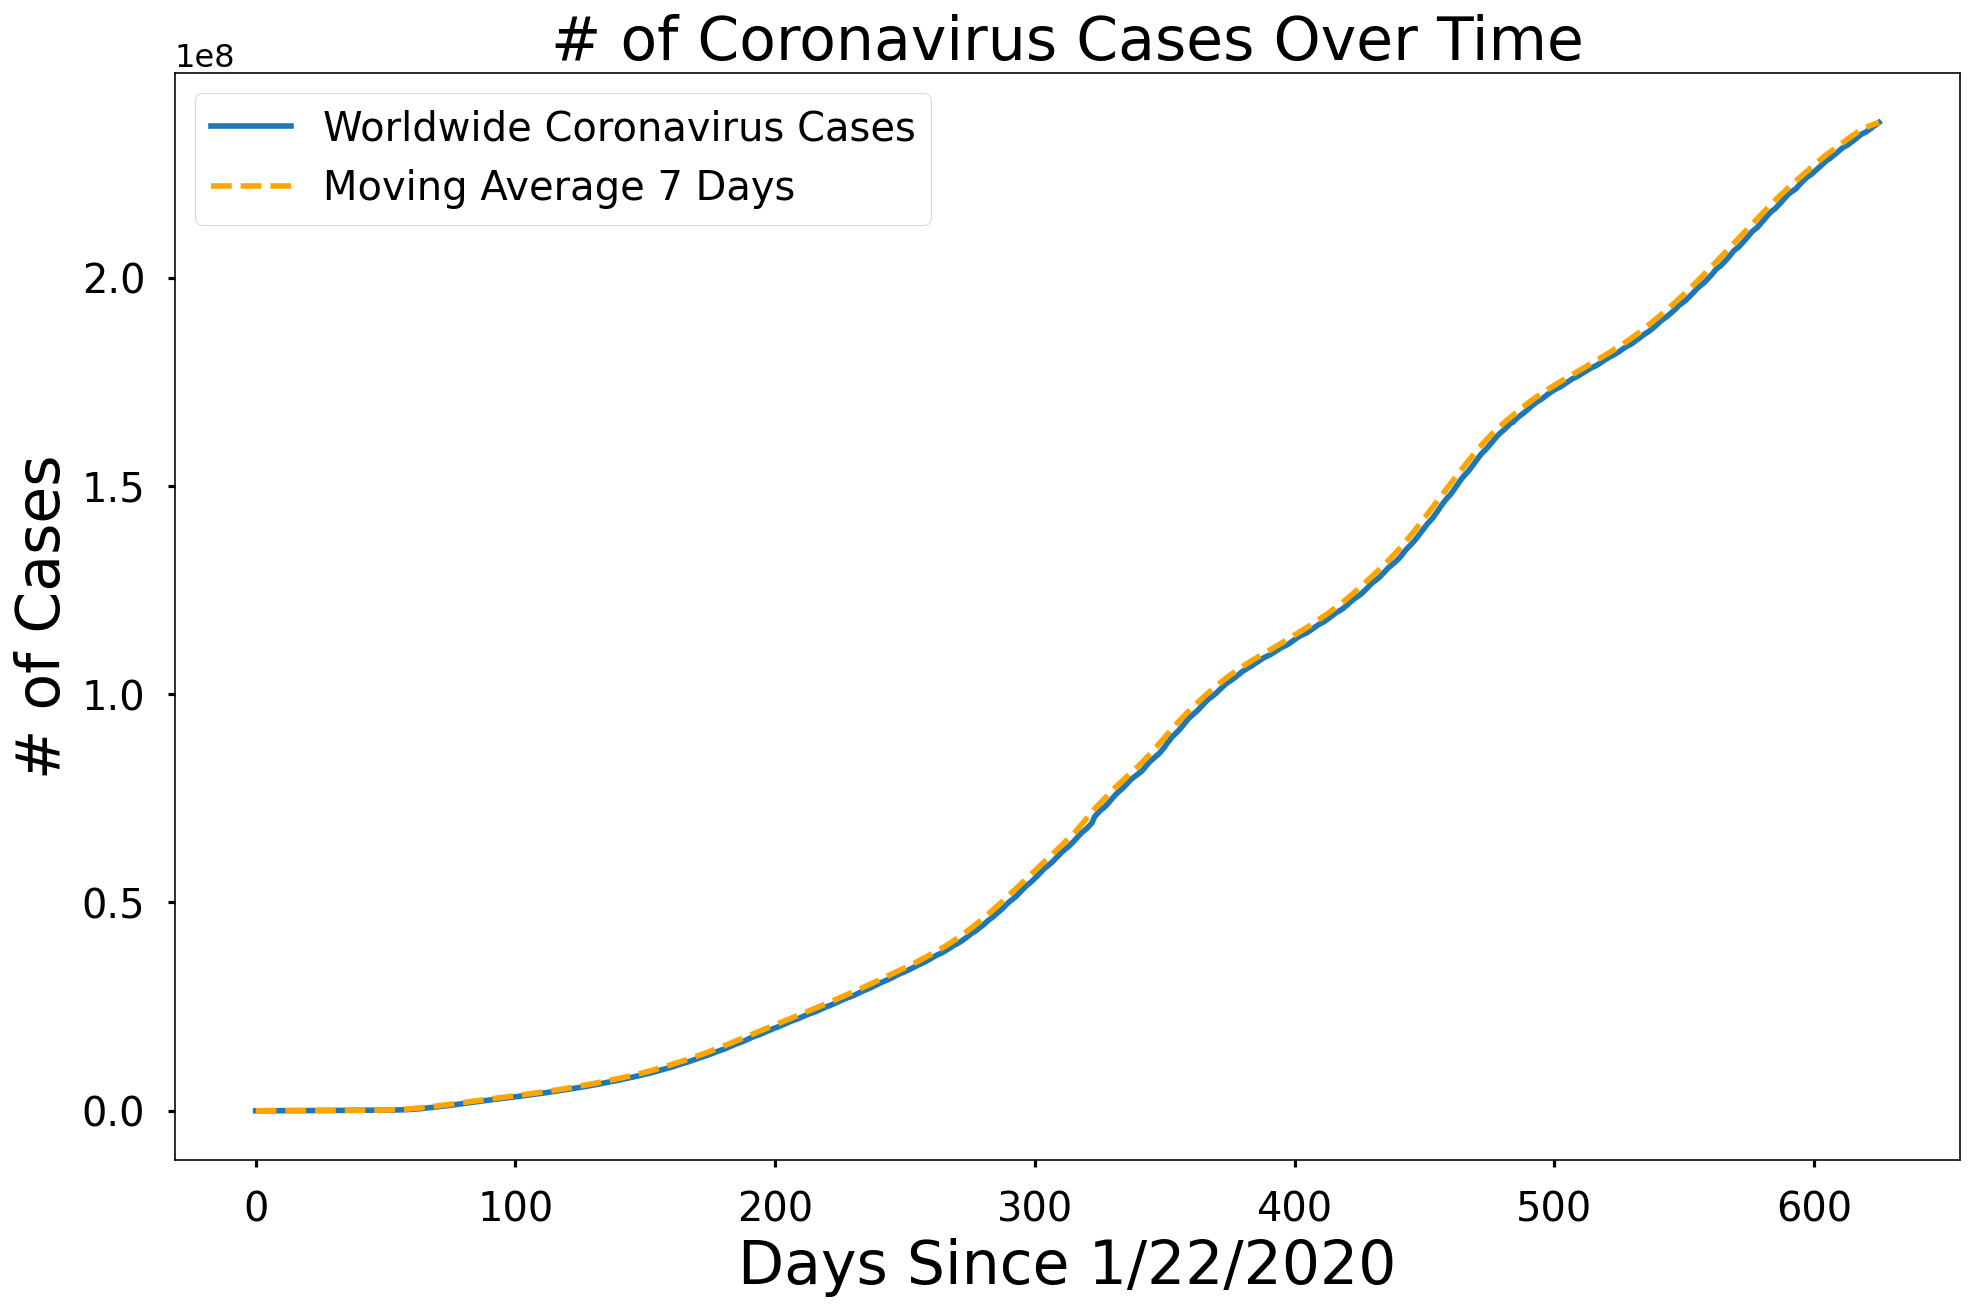

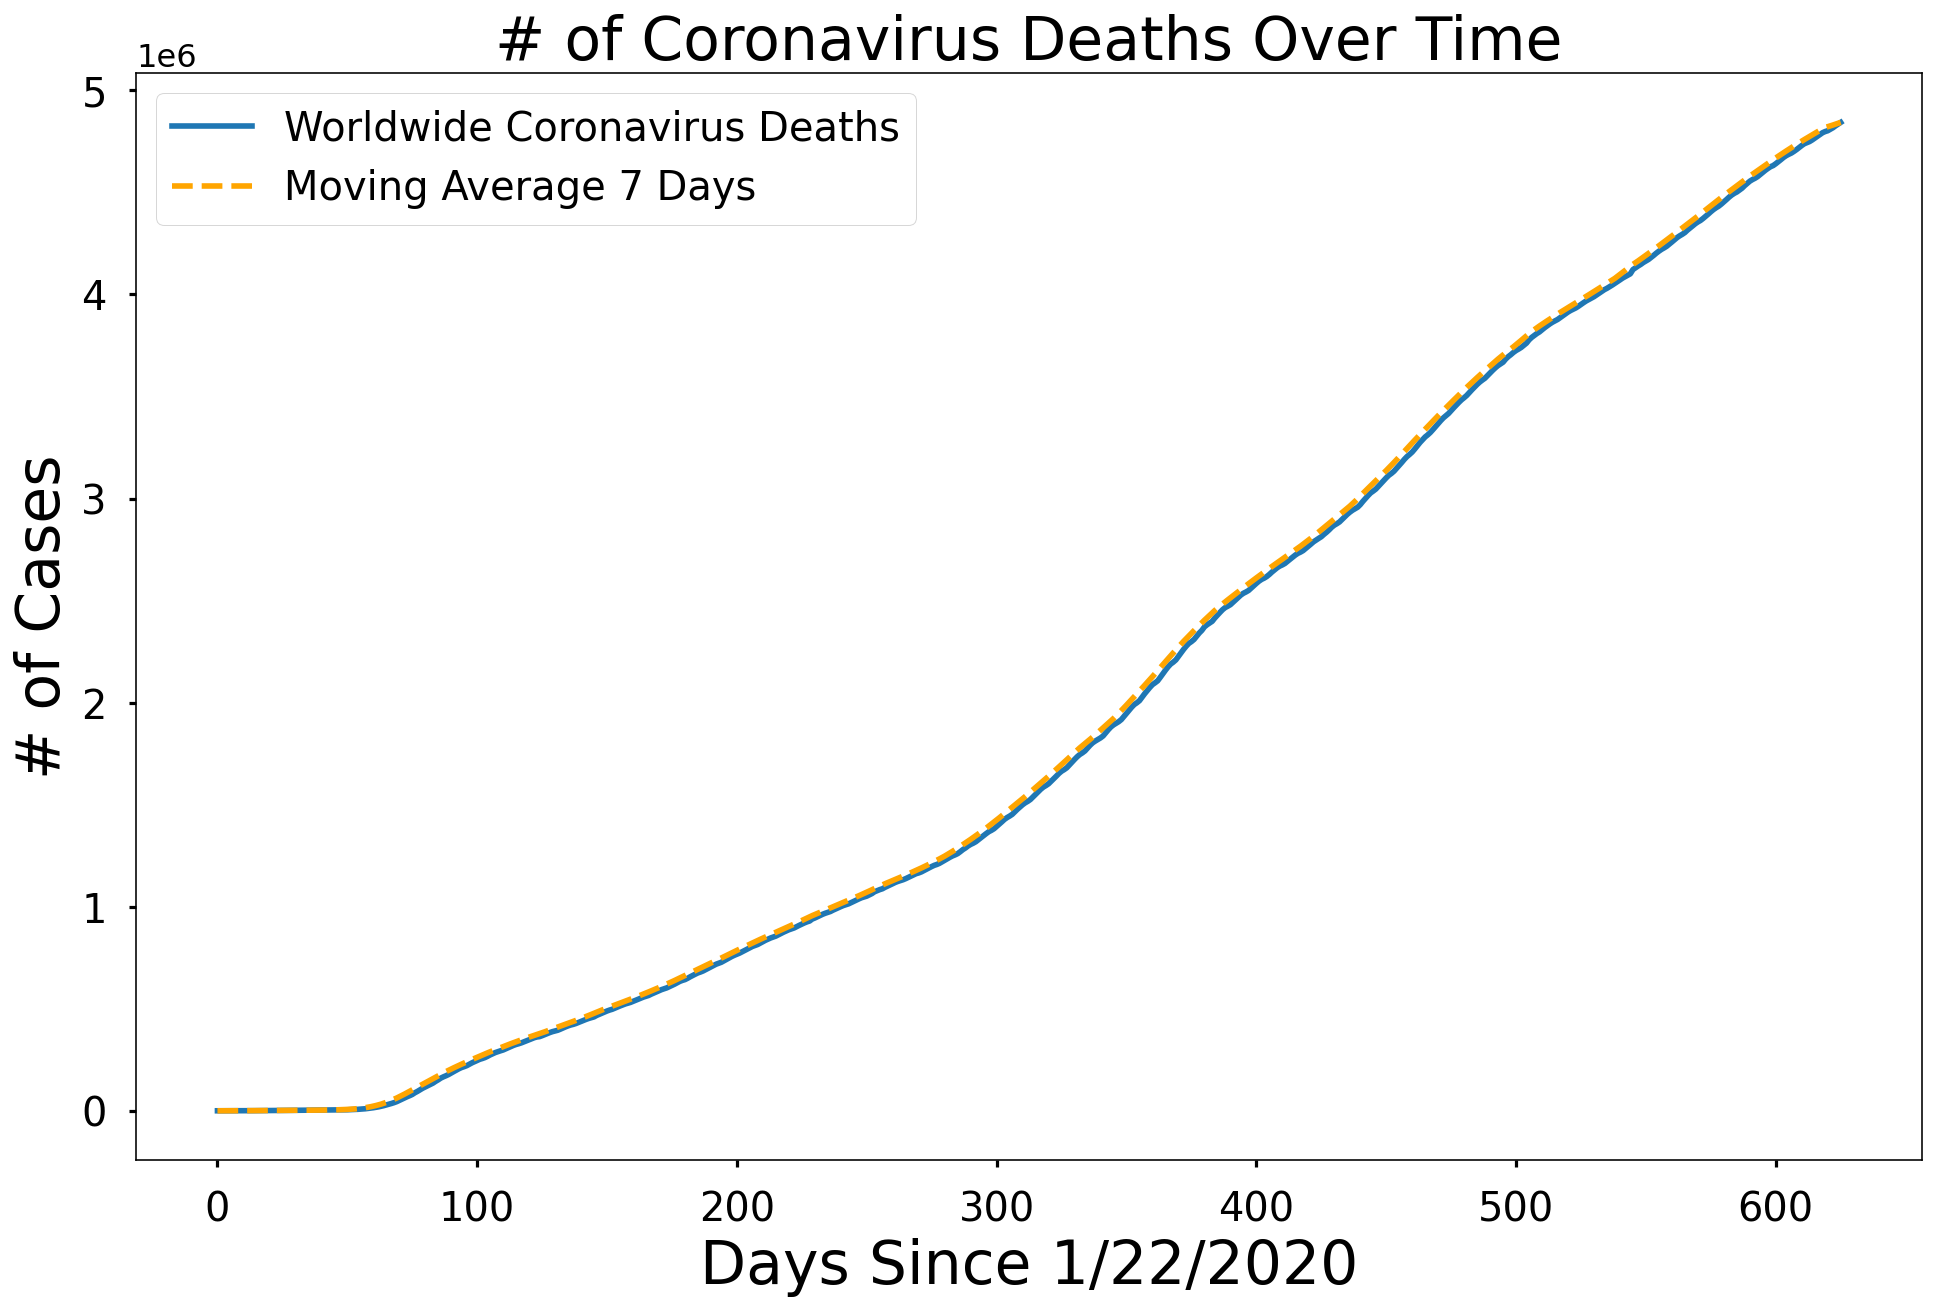

In [89]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

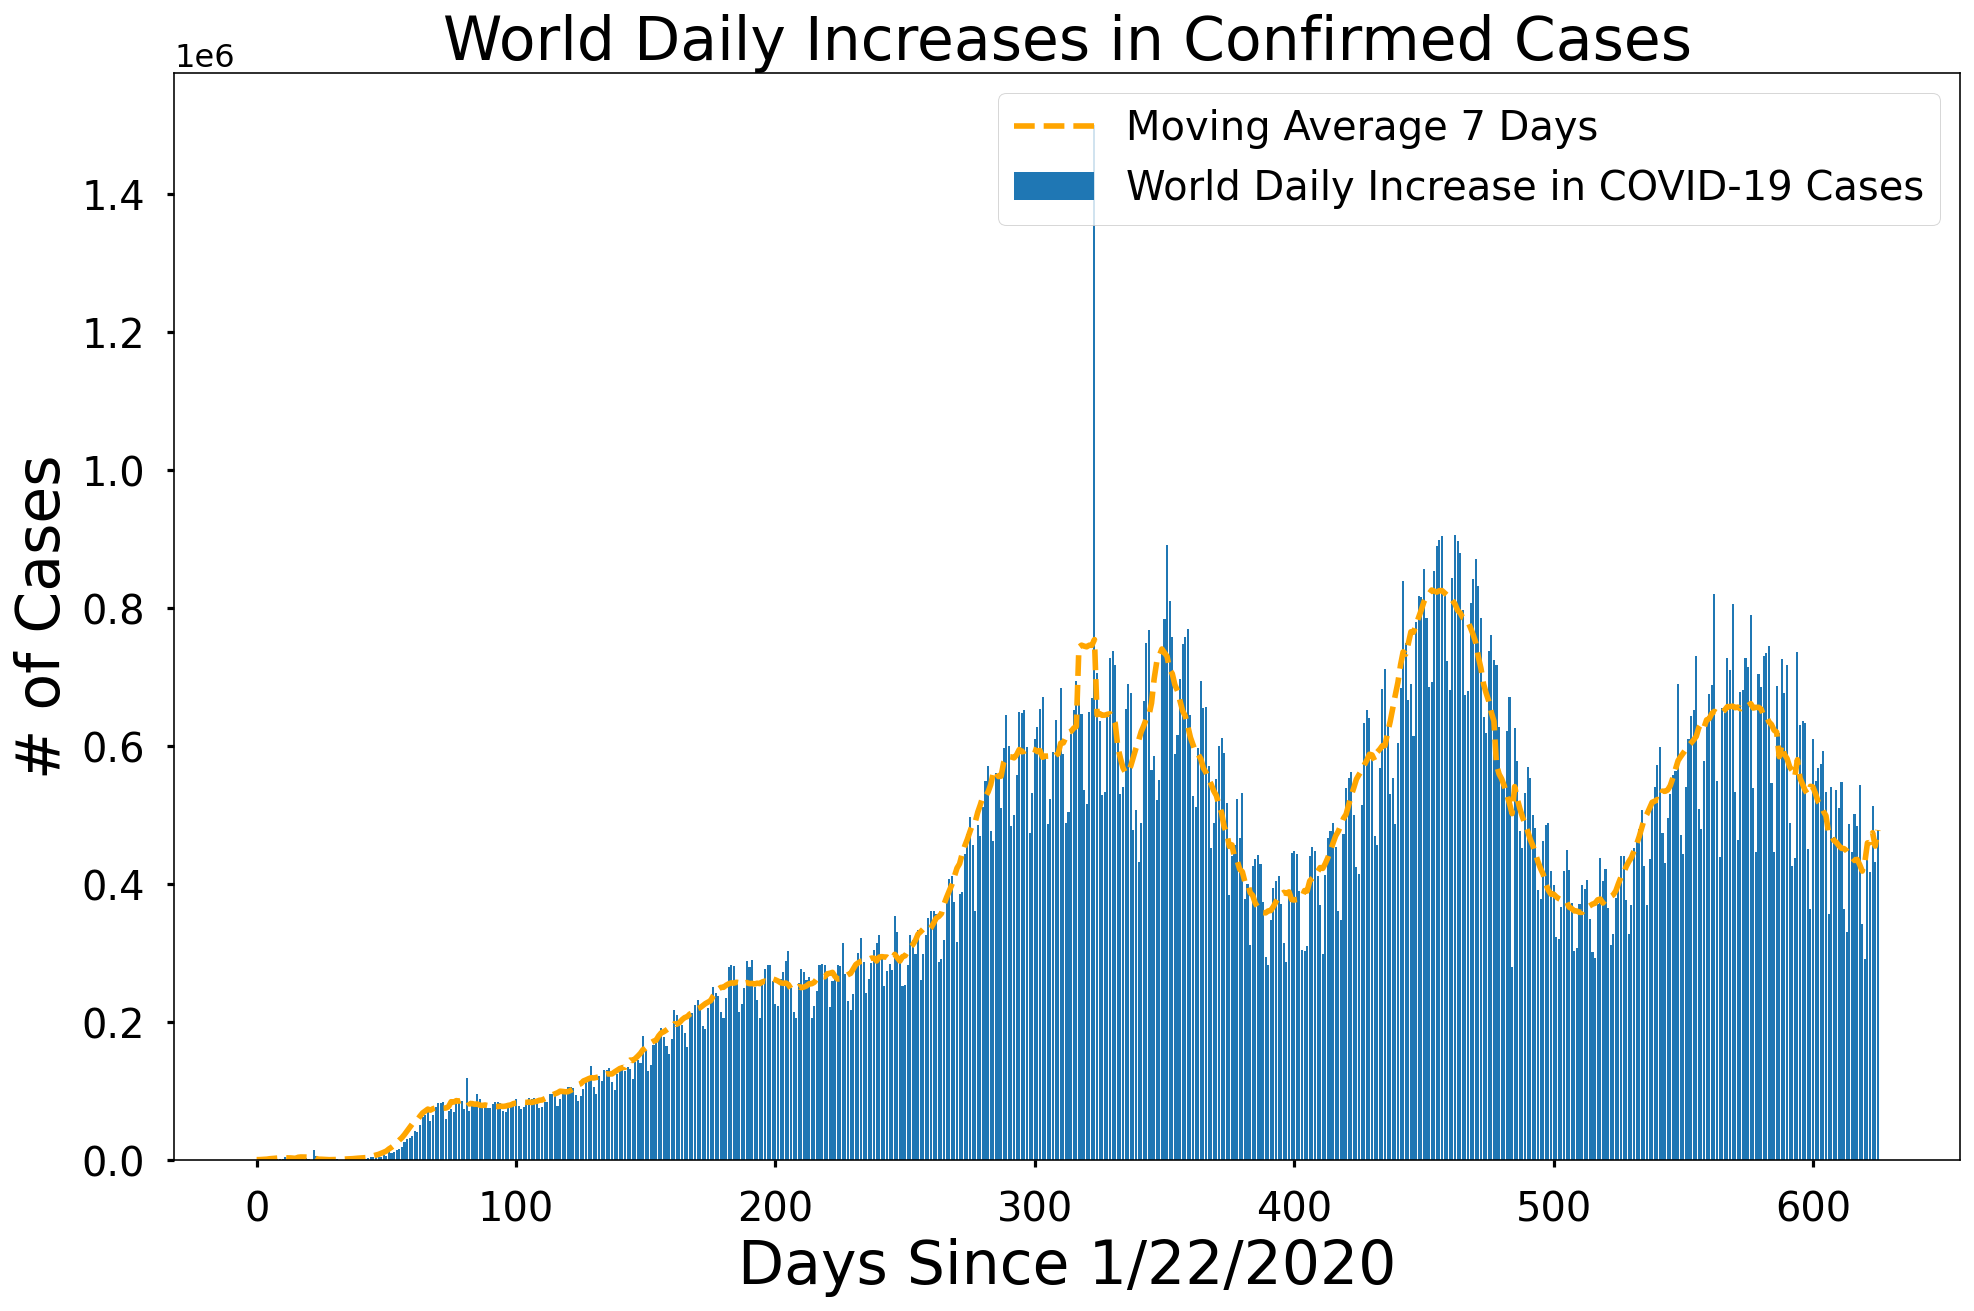

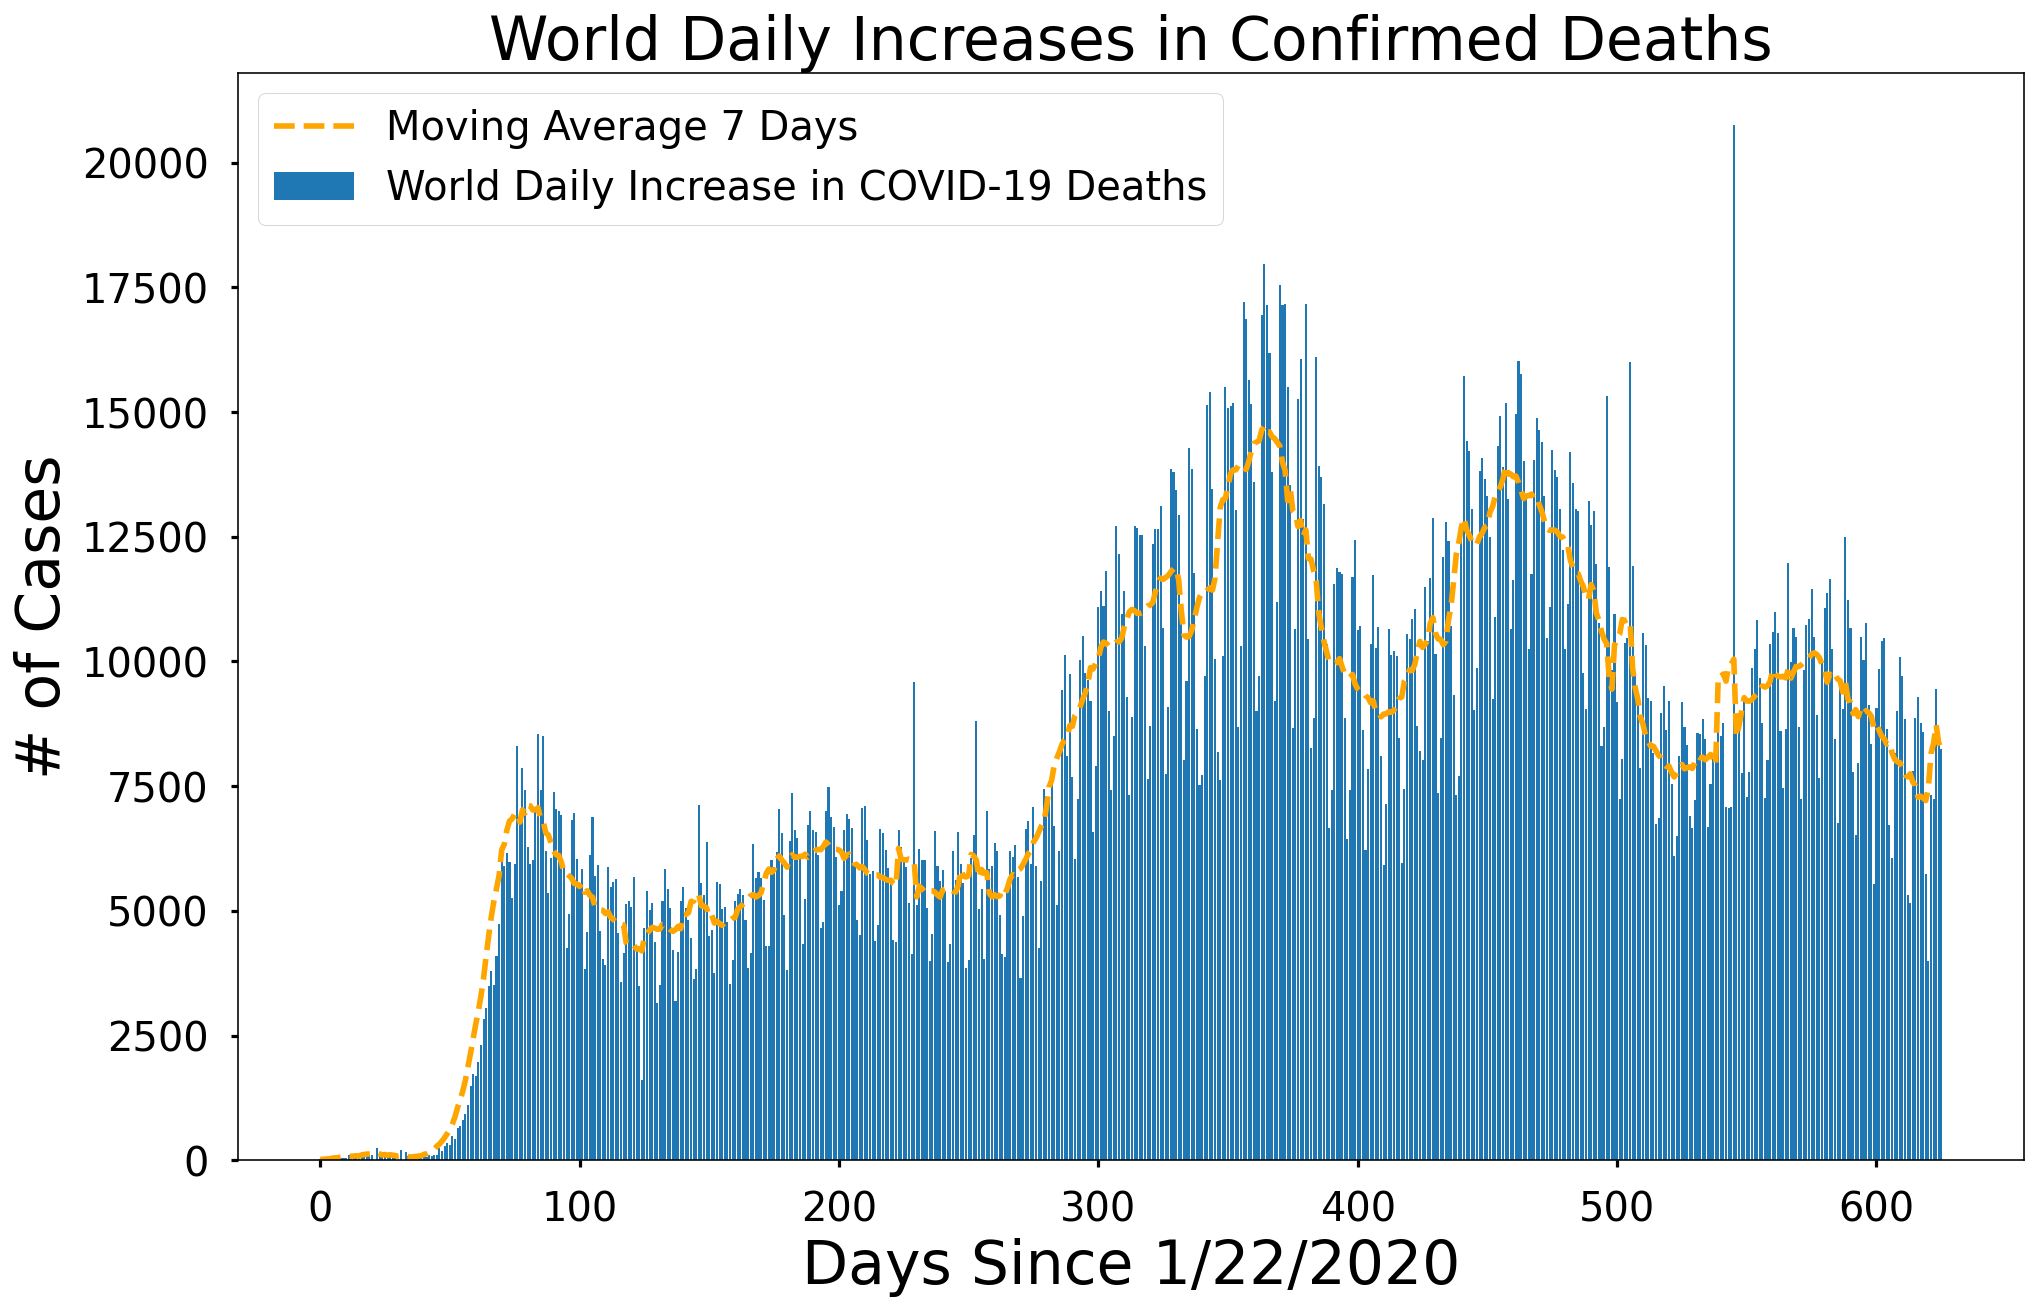

In [90]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# plt.figure(figsize=(16, 10))
# plt.bar(adjusted_dates, world_daily_recovery)
# plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
# plt.title('World Daily Increases in Confirmed Recoveries', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Recoveries'], prop={'size': 20})
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [70]:
def country_plot(x, y1, y2, y3, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
#     recovery_increase_avg = moving_average(y4, window)
    
    plt.figure(figsize=(16, 10))
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

#     plt.figure(figsize=(16, 10))
#     plt.bar(x, y4)
#     plt.plot(x, recovery_increase_avg, color='red', linestyle='dashed')
#     plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Recoveries'.format(country)], prop={'size': 20})
#     plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
#     plt.xlabel('Days Since 1/22/2020', size=30)
#     plt.ylabel('# of Cases', size=30)
#     plt.xticks(size=20)
#     plt.yticks(size=20)
#     plt.show()
      
# helper function for getting country's cases, deaths, and recoveries        
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
#     country_recoveries = []  
    
    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
#         country_recoveries.append(recoveries_df[recoveries_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths)
    
    
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
#     country_daily_recovery = daily_increase(country_recoveries)
    
    country_plot(adjusted_dates, country_cases, country_daily_increase, country_daily_death, country_name)
    

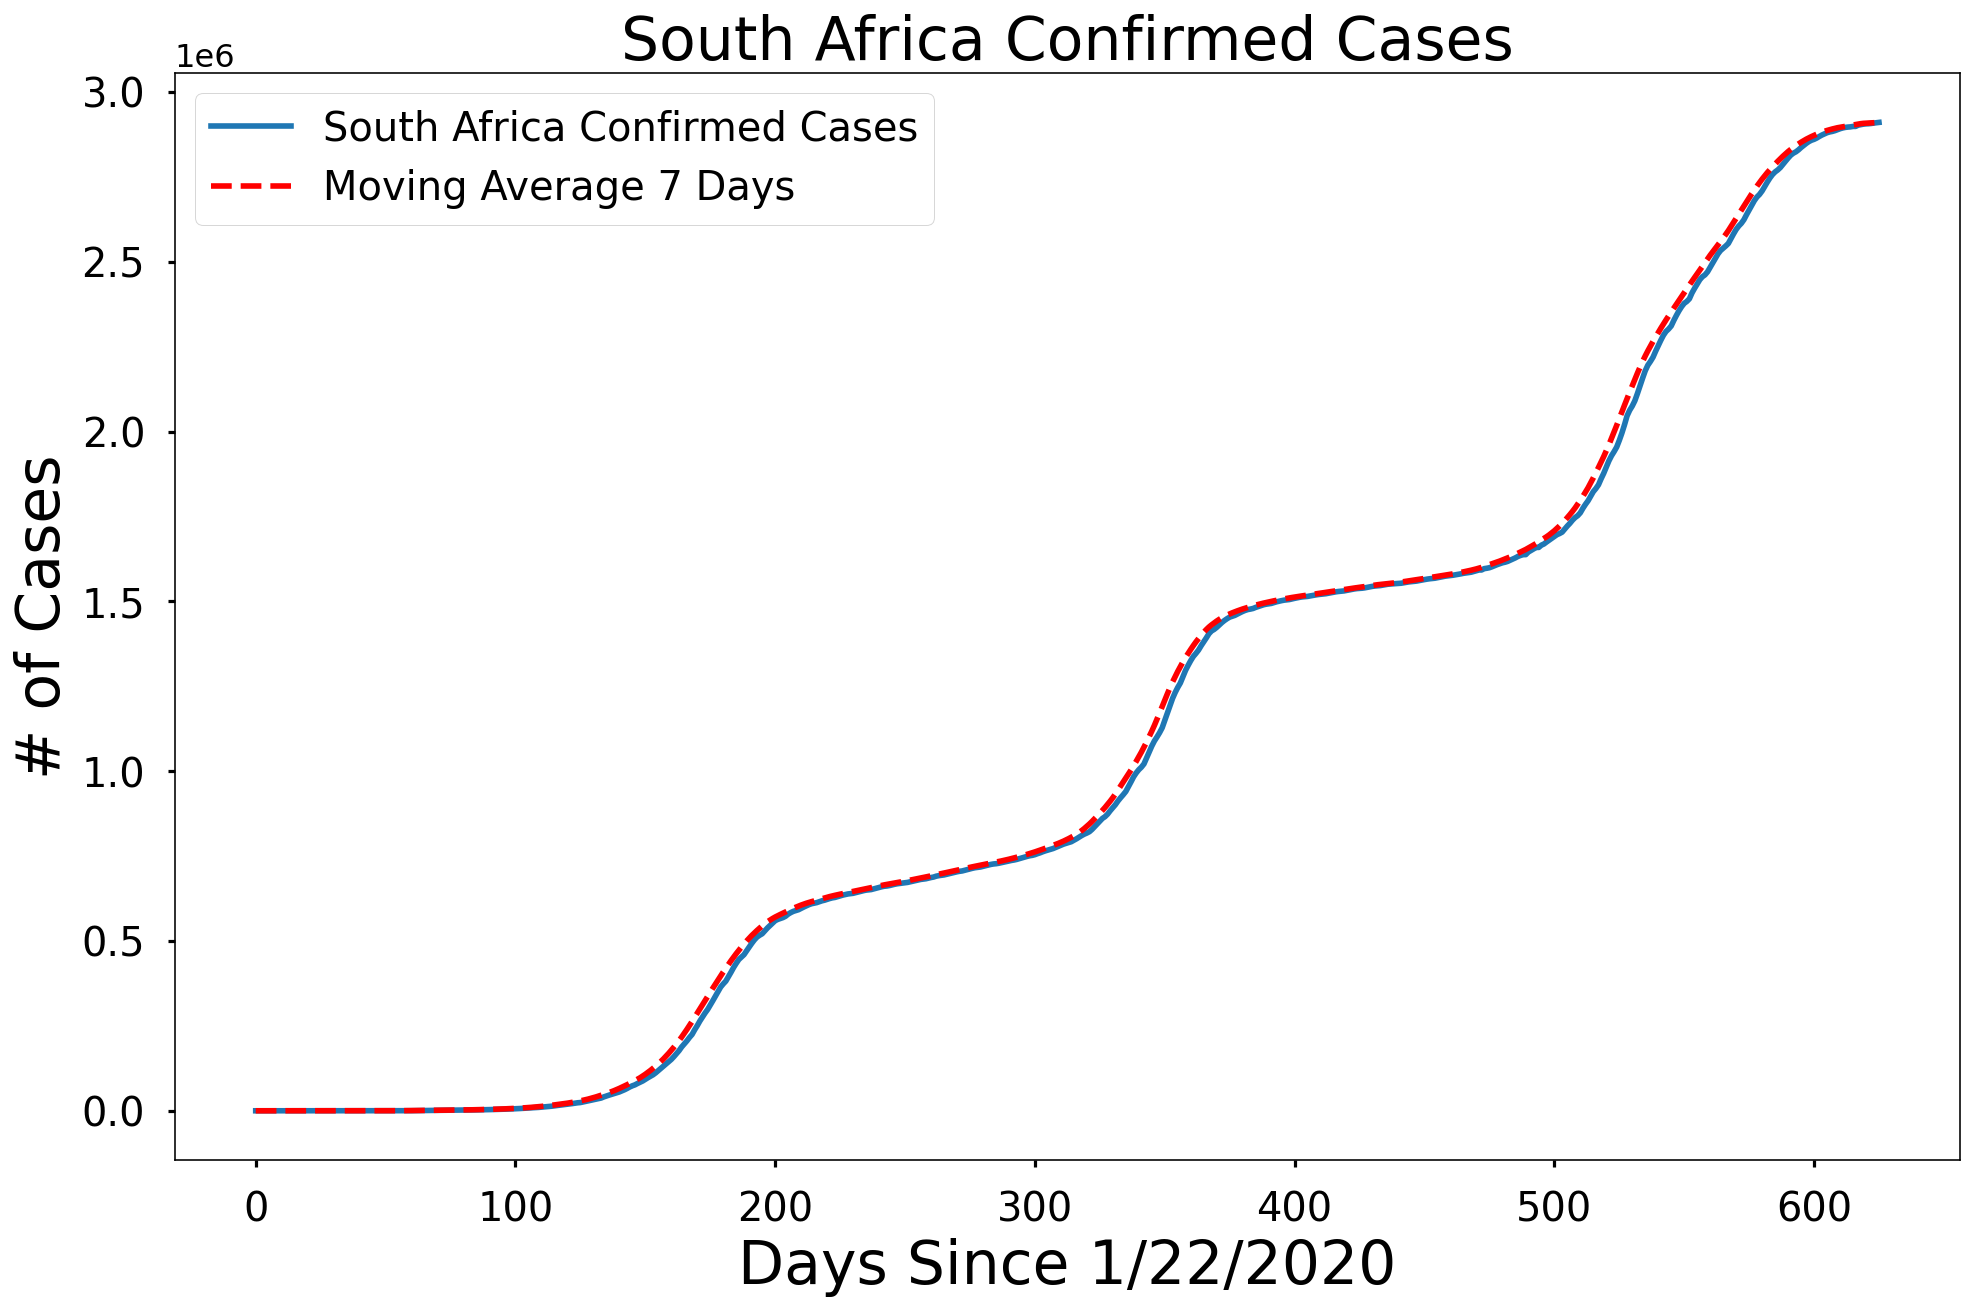

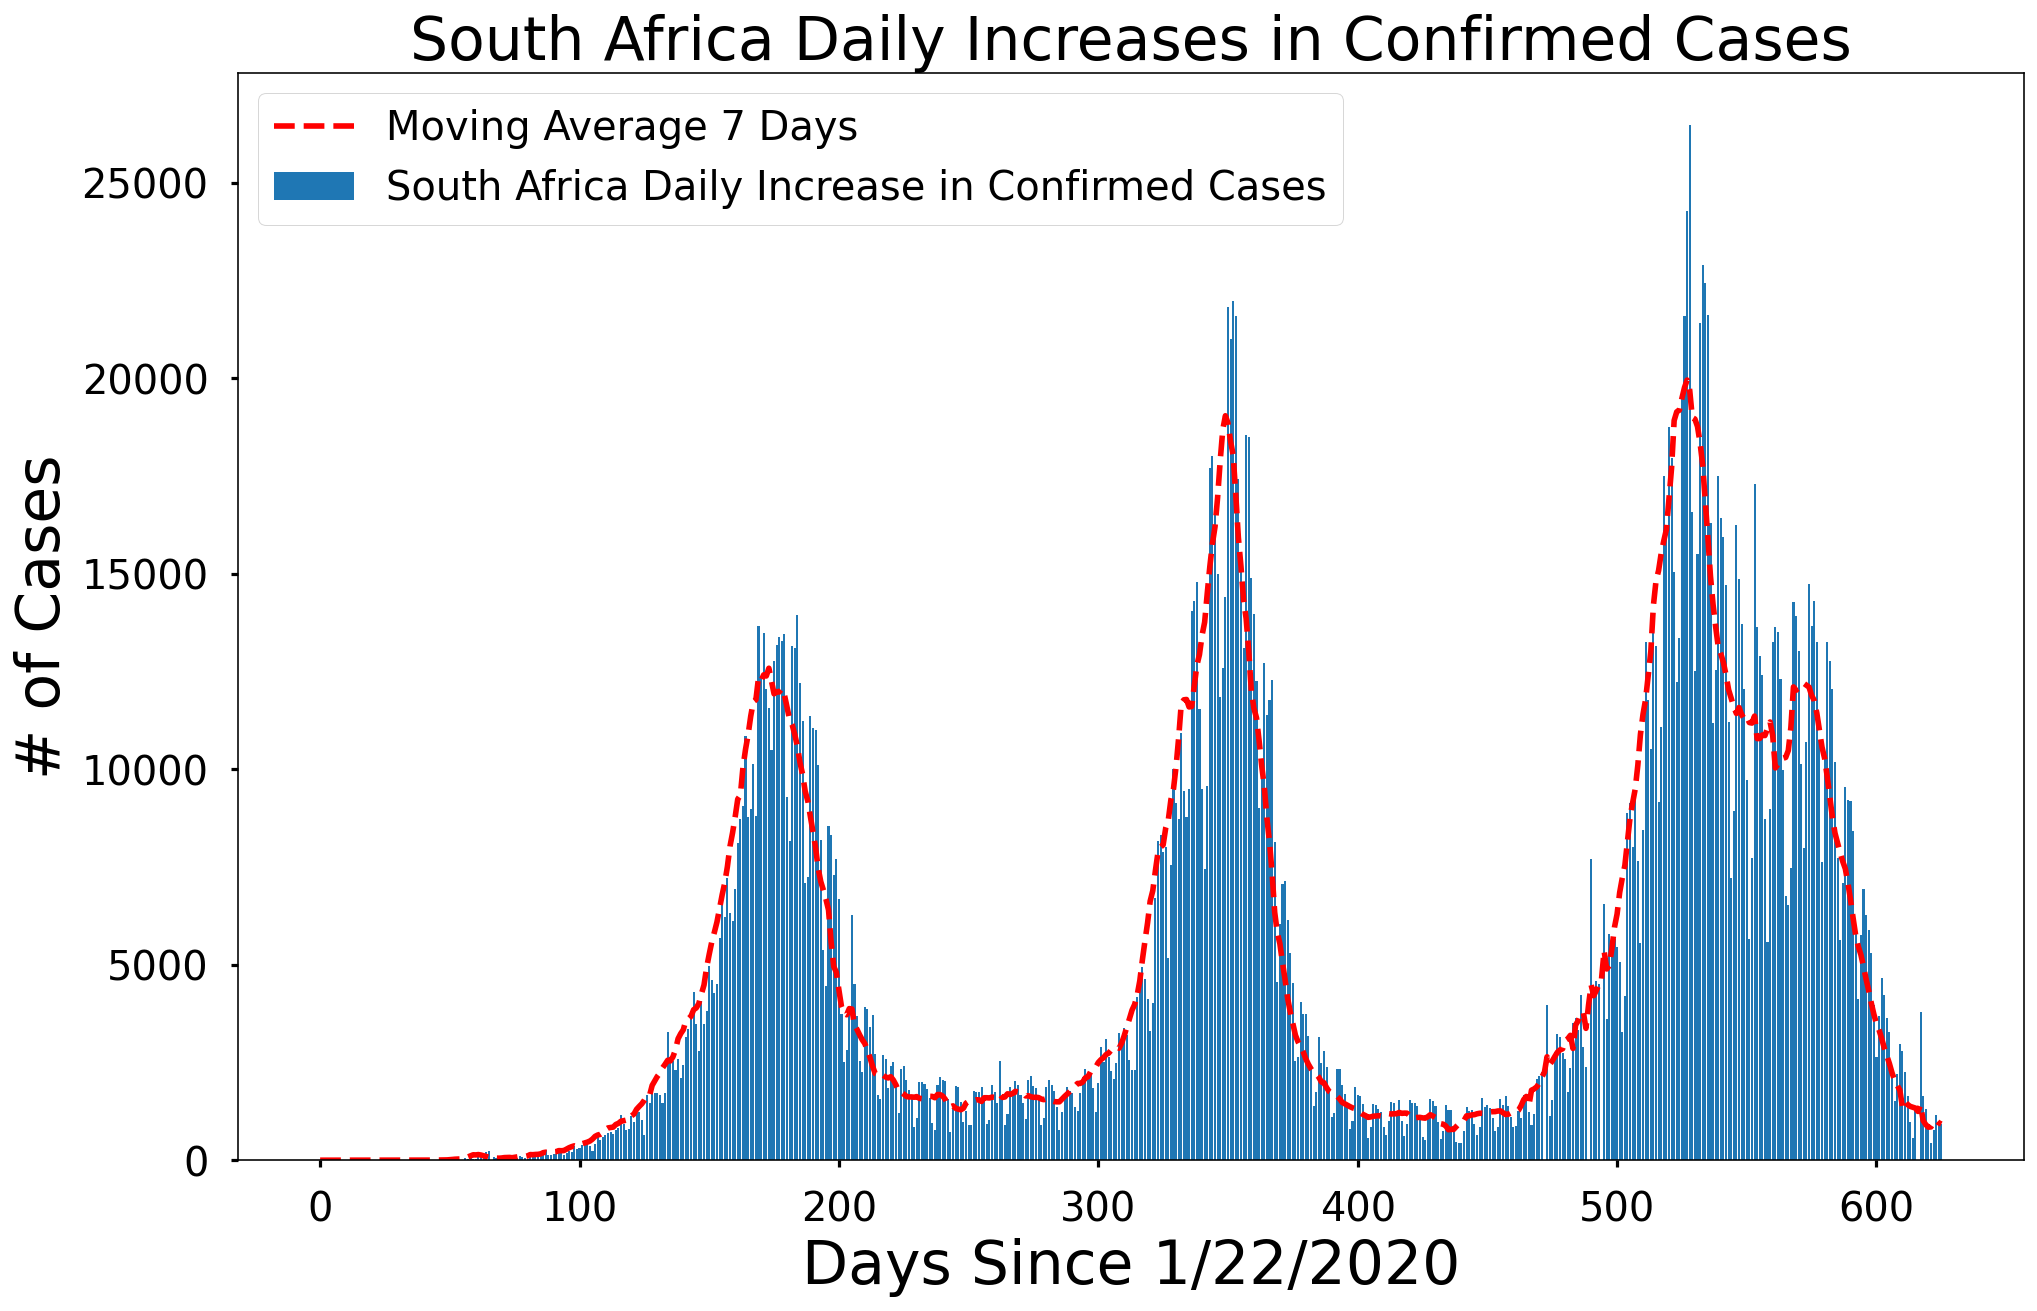

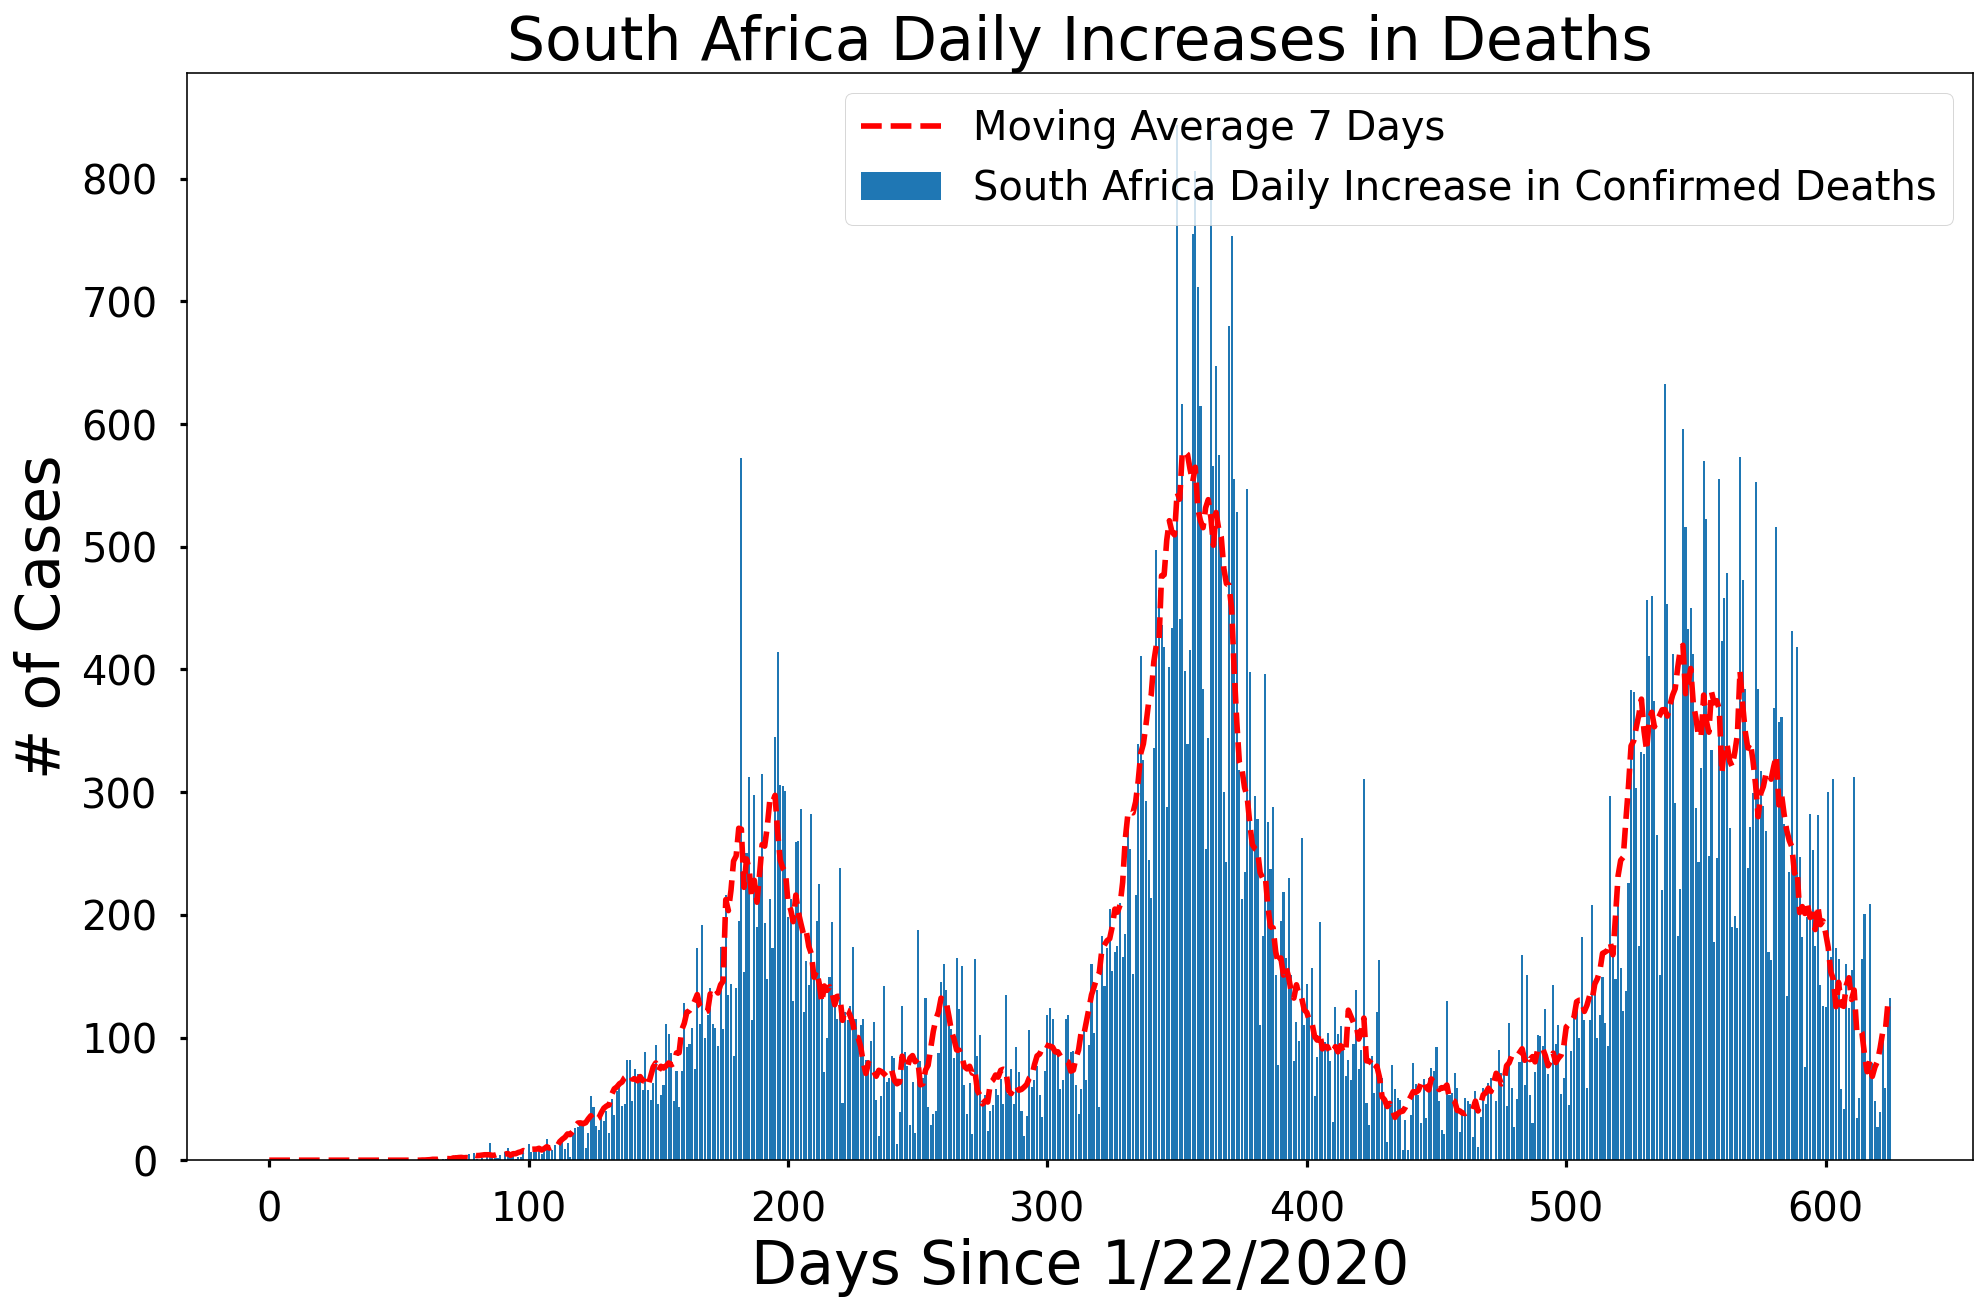

In [71]:
#countries = ['US', 'Russia', 'India', 'Brazil', 'South Africa', 'China', 'Italy',
#             'Germany', 'Spain', 'France', 'United Kingdom', 'Peru', 'Mexico', 'Colombia', 'Argentina', 'Saudi Arabia', 'Iran', 'Bangladesh',
#            'Pakistan', 'Turkey', 'Philippines', 'Iraq', 'Indonesia', 'Israel', 'Ukraine', 'Ecuador', 'Bolivia', 'Netherlands', 'Belgium', 'Poland', 'Czechia', 'Switzerland',
#            'Romania', 'Morocco','Portugal', 'Austria', 'Sweden'] 
countries = ['South Africa']
for country in countries:
    country_visualizations(country)

In [72]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [73]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

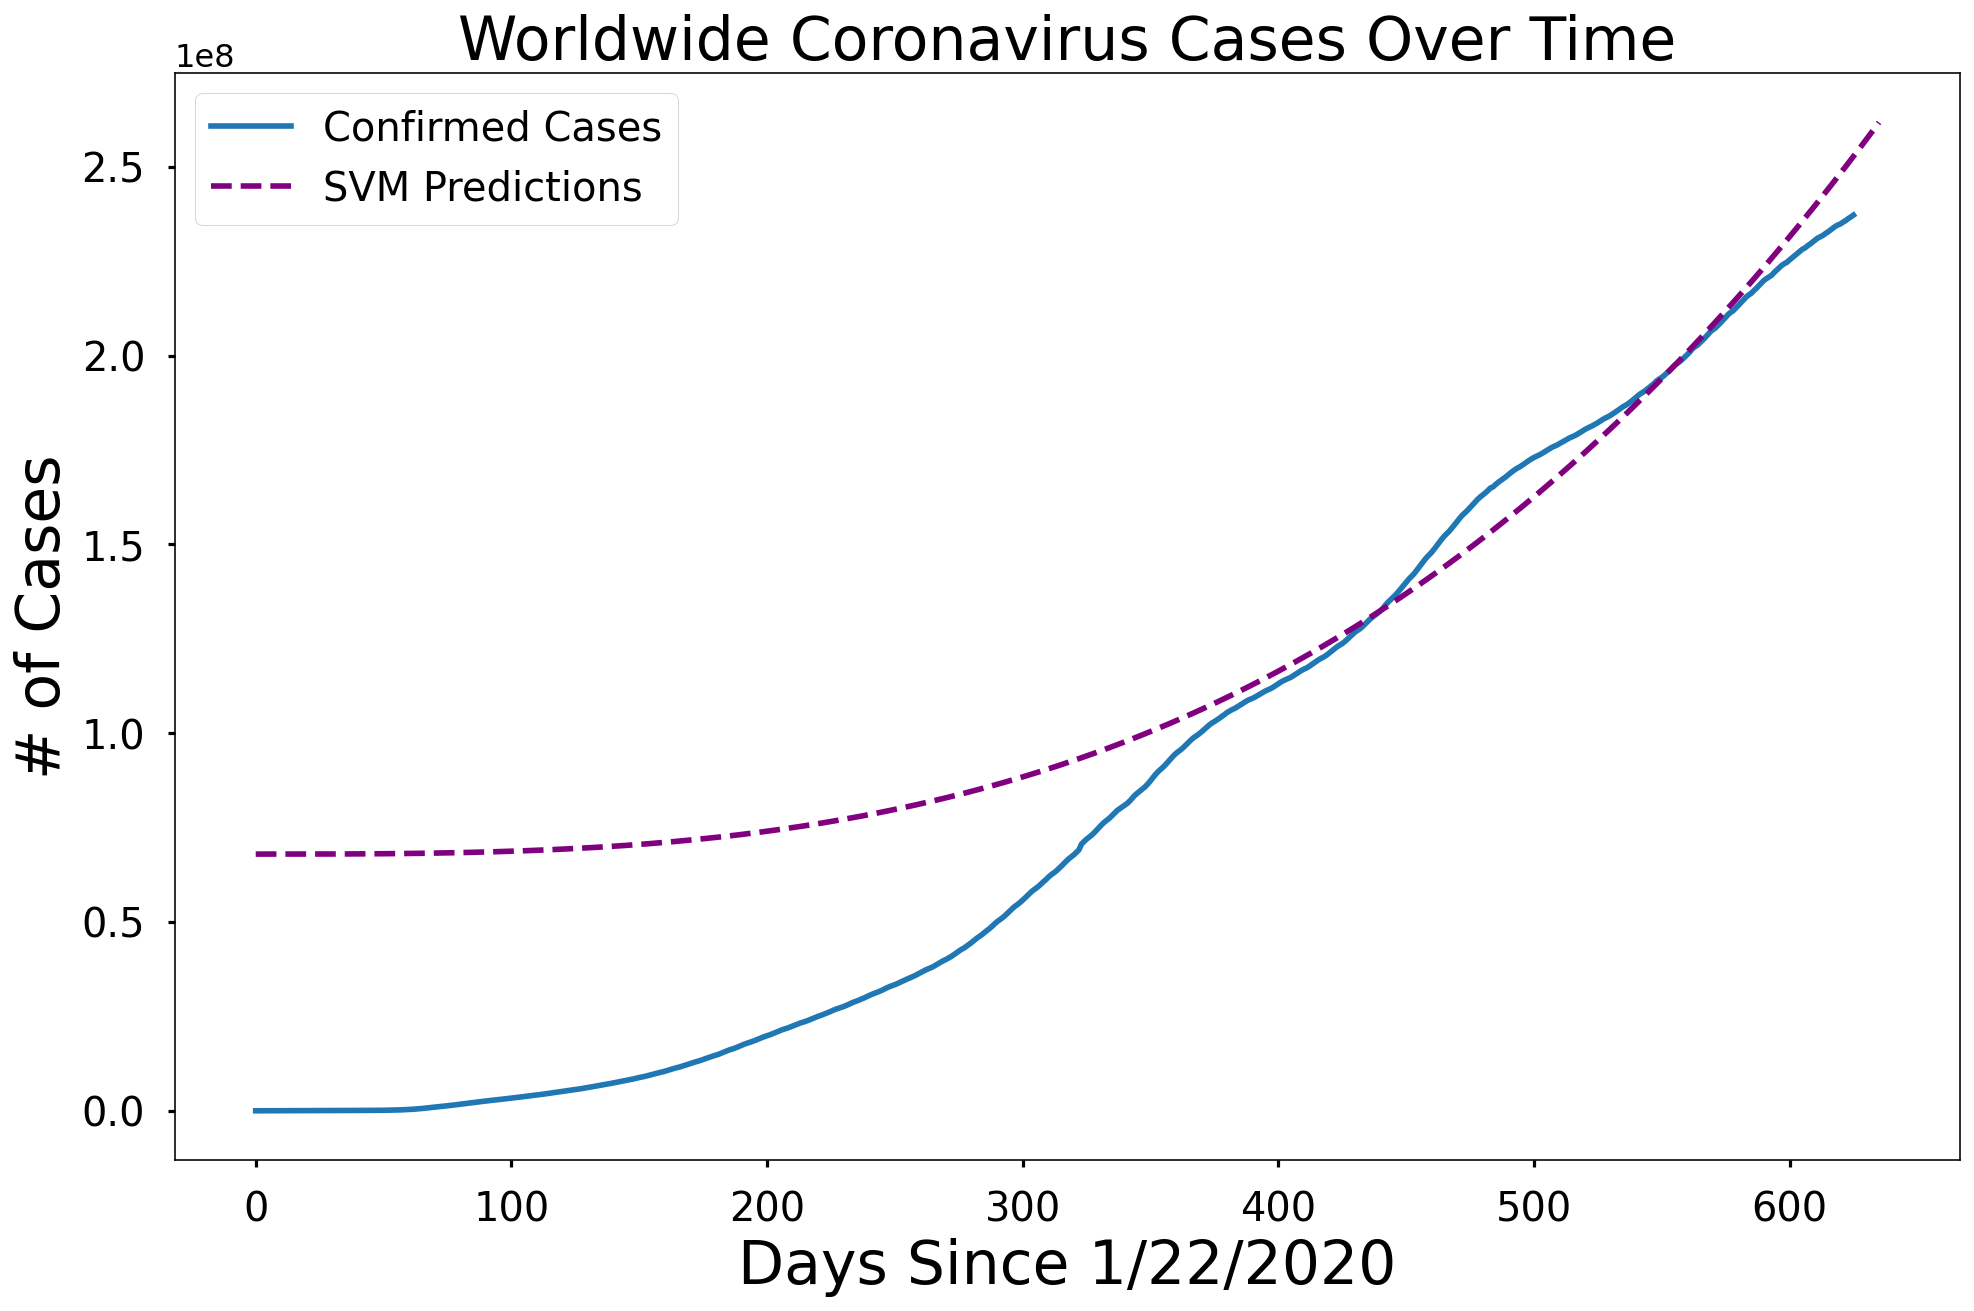

In [74]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')